<a id="section-one"></a>
## Importing Dependencies

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [ ]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras import datasets, layers, models
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import numpy as np

<a id="section-two"></a>
## Reading dataset & setting train and test data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving PCOS-IMAGE-DATASET-main.zip to PCOS-IMAGE-DATASET-main.zip


In [ ]:
# Extract the contents of the zip file
import zipfile
import io

# Assuming 'uploaded' is a dictionary with filenames as keys and file data as values
for name, data in uploaded.items():
    print(f"Processing file: {name}")
    print(f"File size: {len(data)} bytes")
    try:
        with zipfile.ZipFile(io.BytesIO(data)) as zip_ref:
            zip_ref.extractall('/content/PCOS-IMAGE-DATASET-main')
            print(f"Contents of {name} extracted successfully.")
    except zipfile.BadZipFile:
        print(f"Error: The file {name} is not a valid zip file.")
    except Exception as e:
        print(f"An error occurred: {e}")

Processing file: PCOS-IMAGE-DATASET-main.zip
File size: 44286537 bytes
Contents of PCOS-IMAGE-DATASET-main.zip extracted successfully.


In [ ]:
train = "/content/PCOS-IMAGE-DATASET-main/PCOS-IMAGE-DATASET-main/PCOS"
test = "/content/PCOS-IMAGE-DATASET-main/PCOS-IMAGE-DATASET-main/PCOS"

<a id="section-four"></a>
## Data Preprocessing

* The reason for Standardizing/Normalizing is to convert all pixel values to values between 0 and 1.
* The reason for converting type to float to normalize correctly.
* The reason for using to_categorical is that the loss function that we will be using in this code (categorical_crossentropy) when compiling the model needs data to be one hot encoded.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

In [ ]:
# Converting the pixels data to float type
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Standardizing (255 is the total number of pixels an image can have)
train_images = train_images / 255
test_images = test_images / 255

# One hot encoding the target class (labels)
num_classes = 10
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

In [ ]:
train_images.shape

(50000, 32, 32, 3)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train,label_mode="binary",shuffle=True,seed=12,
    validation_split= 0.20,subset="training",image_size=(256,256),batch_size=32)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test,validation_split= 0.20,seed=12,subset="validation",image_size=(256,256),batch_size=32)

Found 1434 files belonging to 2 classes.
Using 1148 files for training.
Found 1434 files belonging to 2 classes.
Using 286 files for validation.


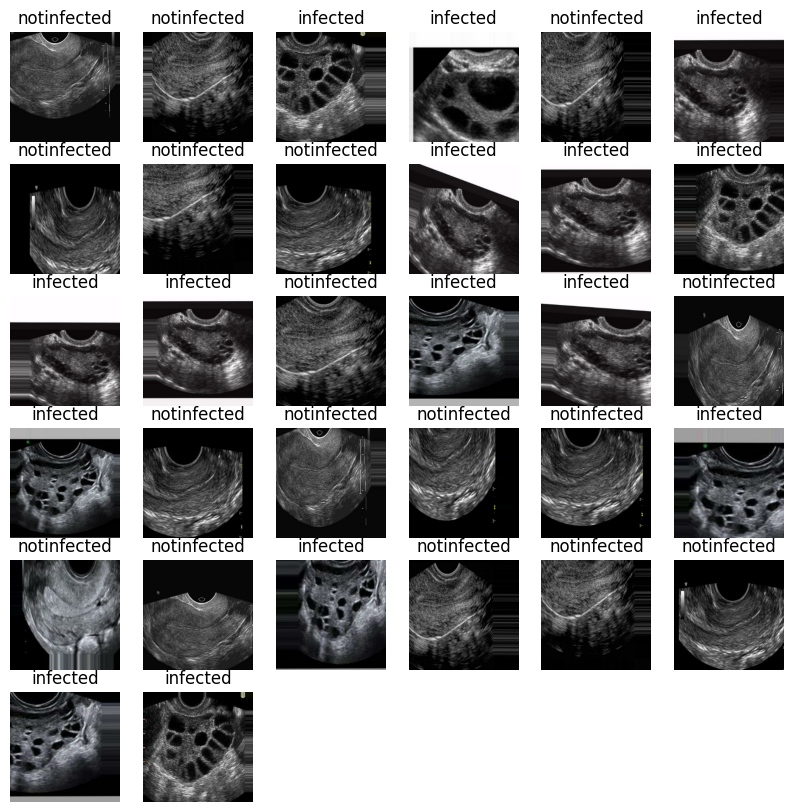

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
class_names = train_ds.class_names
for images, labels in train_ds.take(2):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

In [ ]:
# data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             #width_shift_range=0.2,
                             #height_shift_range=0.2,
                             horizontal_flip = True,
                             vertical_flip=True,
                             rotation_range=20,
                             validation_split=0.2,
                             fill_mode='nearest'
                             )
# prepare an iterators for each dataset
train_ds = datagen.flow_from_directory(train,
                                       class_mode='categorical',
                                       classes=['infected', 'notinfected'],
                                       target_size=(224, 224),
                                       batch_size= batch_size,
                                       subset='training',
                                       seed=12)
# prepare an iterators for each dataset
val_ds = datagen.flow_from_directory(test,
                                     class_mode='categorical',
                                     classes=['infected', 'notinfected'],
                                     target_size=(224, 224),
                                     batch_size= batch_size,
                                     subset='validation',
                                     seed=12)


Found 1148 images belonging to 2 classes.
Found 286 images belonging to 2 classes.


In [ ]:
# 1. Neural Network (NN)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

nn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((3, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Output for 2 classes
])

nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
nn_model.fit(train_ds, validation_data=val_ds, epochs=5)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.6239 - loss: 0.8339 - val_accuracy: 0.8811 - val_loss: 0.2685
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.9294 - loss: 0.1917 - val_accuracy: 0.9860 - val_loss: 0.0551
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9936 - loss: 0.0504 - val_accuracy: 1.0000 - val_loss: 0.0255
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.9940 - loss: 0.0306 - val_accuracy: 1.0000 - val_loss: 0.0119
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.9953 - loss: 0.0171 - val_accuracy: 0.9965 - val_loss: 0.0104


<a id="section-five"></a>
## Building the CNN Model

In [ ]:
# 2. Convolution Neural Network (CNN)
cnn_model = Sequential()

cnn_model.add(Conv2D(12, (5,5),padding='SAME',activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(8, (5,5),padding='SAME',activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(4, (5,5),padding='SAME',activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Flatten())

cnn_model.add(Dense(2,activation='softmax'))

opt=Adam(learning_rate=0.01)
cnn_model.compile(optimizer=opt, loss=BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
earlyStopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1,patience=15)

<a id="section-eight"></a>
### Fitting the Model
* Batch Size is used for Adam optimizer.
* Epochs - One epoch is one complete cycle (forward pass + backward pass).

In [ ]:
history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[earlyStopping],
    batch_size=batch_size,
    verbose=2,
    epochs=5)

Epoch 1/5
36/36 - 100s - 3s/step - accuracy: 0.6794 - loss: 0.5339 - val_accuracy: 0.8706 - val_loss: 0.2851
Epoch 2/5
36/36 - 139s - 4s/step - accuracy: 0.9129 - loss: 0.2214 - val_accuracy: 0.9580 - val_loss: 0.1113
Epoch 3/5
36/36 - 146s - 4s/step - accuracy: 0.9713 - loss: 0.0927 - val_accuracy: 0.9685 - val_loss: 0.0834
Epoch 4/5
36/36 - 135s - 4s/step - accuracy: 0.9782 - loss: 0.0709 - val_accuracy: 0.9790 - val_loss: 0.0513
Epoch 5/5
36/36 - 94s - 3s/step - accuracy: 0.9861 - loss: 0.0425 - val_accuracy: 0.9895 - val_loss: 0.0333


In [ ]:
cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 224, 224, 12)        │             912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 112, 112, 12)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 112, 112, 8)         │           2,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 56, 56, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 56, 56, 4)           │             804 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 28, 28, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │           6,274 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,196 (121.86 KB)

 Trainable params: 10,398 (40.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,798 (81.25 KB)

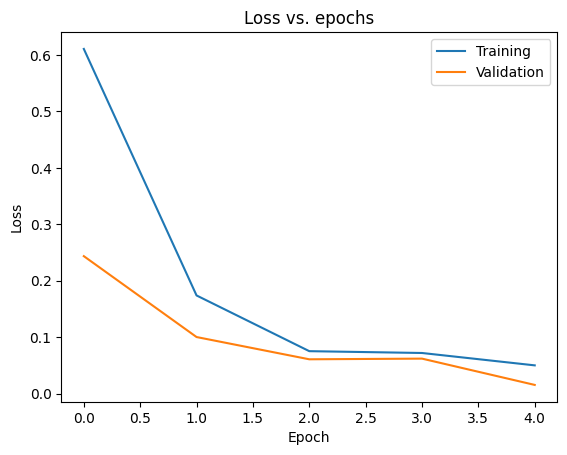

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

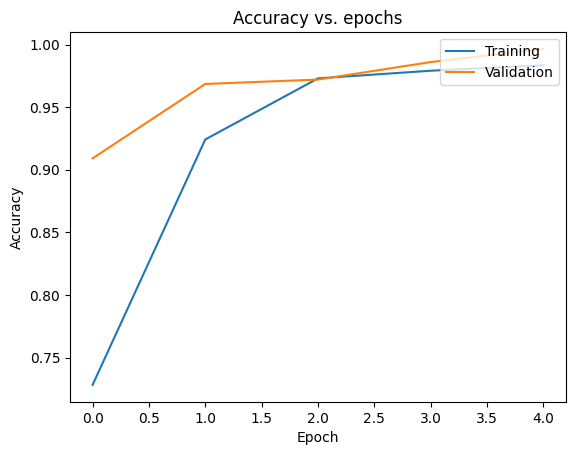

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

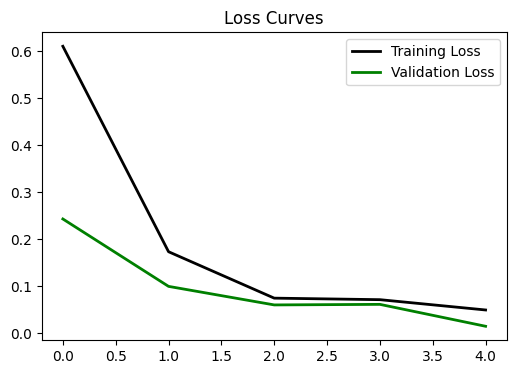

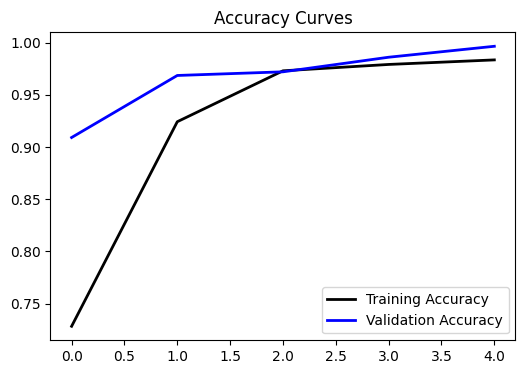

In [ ]:
# Plot the loss and accuracy curves
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('Loss Curves')

plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.title('Accuracy Curves')
plt.show()

In [ ]:
# 3. k-Nearest Neighbors (KNN)
# Extract features and labels from train_ds and val_ds
def extract_data(ImageDataGenerator):
    features, labels = [], []
    for batch_images, batch_labels in ImageDataGenerator:
        features.append(batch_images.reshape(batch_images.shape[0], -1))
        labels.append(np.argmax(batch_labels, axis=1))
        if len(features) * ImageDataGenerator.batch_size >= ImageDataGenerator.samples:
            break
    return np.vstack(features), np.hstack(labels)

X_train, y_train = extract_data(train_ds)
X_val, y_val = extract_data(val_ds)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train and evaluate KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_val_scaled)
print("KNN Accuracy:", accuracy_score(y_val, y_pred))

KNN Accuracy: 0.7202797202797203


In [ ]:
# Train and evaluate SVM
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train_scaled, y_train)
y_pred = svm.predict(X_val_scaled)
print("SVM Accuracy:", accuracy_score(y_val, y_pred))

SVM Accuracy: 0.8951048951048951


**Transfer Learning**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(32,32, 3))
base_model.trainable = False ## Not trainable weights

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load and preprocess the image
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)  # Load image and resize
    img_array = img_to_array(img)  # Convert image to numpy array
    img_array = img_array / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for batch size
    return img_array

# Function to predict on a folder of images
def predict_folder(folder_path, cnn_model, class_names=['infected', 'notinfected'], target_size=(224, 224)):
    true_labels = []
    predicted_labels = []

    # Loop over the folders (infected, noninfected)
    for class_name in class_names:
        class_folder = os.path.join(folder_path, class_name)

        # Loop over all images in the folder
        for image_name in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_name)

            if image_path.endswith(('jpg', 'jpeg', 'png')):  # Check if the file is an image
                # Preprocess the image and make predictions
                img = load_and_preprocess_image(image_path, target_size)
                prediction = cnn_model.predict(img)
                predicted_class = np.argmax(prediction, axis=1)[0]

                # Store true and predicted labels
                true_labels.append(class_name)
                predicted_labels.append(class_names[predicted_class])

    return true_labels, predicted_labels

# Define the folder where the test data is located
test_folder = "/content/PCOS-IMAGE-DATASET-main/PCOS-IMAGE-DATASET-main/PCOS"

# Make predictions on the test folder
true_labels, predicted_labels = predict_folder(test_folder, cnn_model)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

Accuracy: 99.65%


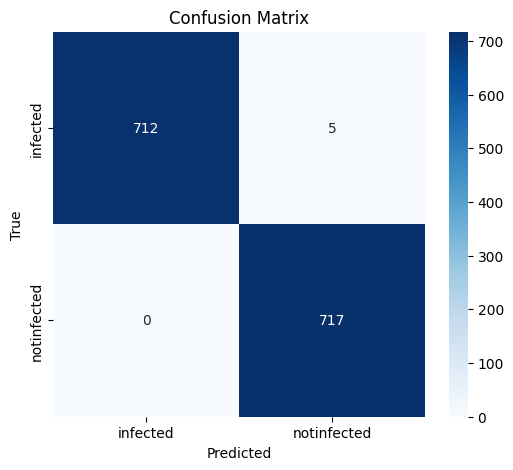

In [38]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=['infected', 'notinfected'])

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['infected', 'notinfected'], yticklabels=['infected', 'notinfected'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [41]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load and preprocess the image
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    # Load image
    img = load_img(image_path, target_size=target_size)

    # Convert image to numpy array
    img_array = img_to_array(img)

    # Rescale pixel values to [0, 1]
    img_array = img_array / 255.0

    # Expand dimensions to match the shape expected by the model
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

# Example of predicting on a single image
image_path = "/content/PCOS-IMAGE-DATASET-main/PCOS-IMAGE-DATASET-main/PCOS/notinfected/img1.jpeg"  # Replace with your image path
processed_img = load_and_preprocess_image(image_path)

# Predict using the model
predictions = cnn_model.predict(processed_img)

# If the model output is probabilities (since you're using softmax), get the class with the highest probability
predicted_class = np.argmax(predictions, axis=1)

# Map the predicted class index back to the original class name
class_names = ['infected', 'notinfected']
predicted_label = class_names[predicted_class[0]]

print(f"Predicted class: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted class: notinfected


In [40]:
# Save the model
cnn_model.save("path/to/save/model.h5")  # for H5 format